In [2]:
pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [3]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 25.5 MB/s eta 0:00:00


# Class Exercise

In [13]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


In [5]:
# --------------------------
# Input Data
# --------------------------
num_products = 12
num_periods = 15

demand = [
    [0, 95, 110, 96, 86, 124, 83, 108, 114, 121, 110, 124, 104, 86, 87],       # Product 1
    [98, 96, 96, 98, 103, 104, 122, 101, 89, 108, 101, 109, 106, 108, 76],     # Product 2
    [106, 0, 89, 123, 96, 105, 83, 82, 112, 109, 119, 85, 99, 80, 123],        # Product 3
    [98, 121, 0, 89, 105, 96, 101, 81, 117, 76, 103, 89, 5, 105, 102],         # Product 4
    [0, 124, 113, 123, 79, 111, 98, 97, 80, 98, 124, 78, 108, 0, 109],         # Product 5
    [103, 102, 0, 95, 107, 105, 107, 105, 75, 93, 115, 113, 111, 105, 85],     # Product 6
    [110, 93, 0, 112, 84, 124, 98, 101, 83, 87, 105, 118, 115, 106, 78],       # Product 7
    [85, 92, 101, 110, 93, 96, 120, 109, 121, 87, 92, 85, 91, 93, 109],        # Product 8
    [122, 116, 109, 107, 90, 110, 102, 107, 99, 96, 0, 0, 0, 0, 0],            # Product 9
    [120, 124, 94, 105, 92, 86, 101, 106, 75, 109, 83, 95, 79, 108, 100],      # Product 10
    [117, 96, 78, 100, 98, 87, 114, 107, 110, 94, 104, 101, 108, 110, 80],     # Product 11
    [125, 112, 75, 70, 116, 103, 122, 88, 85, 84, 76, 102, 84, 88, 82]         # Product 12
]

safety_stock = [
    [10] * num_periods,  # Product 1
    [10] * num_periods,  # Product 2
    [10] * num_periods,  # Product 3
    [10] * num_periods,  # Product 4
    [10] * num_periods,  # Product 5
    [10] * num_periods,  # Product 6
    [20] * num_periods,  # Product 7
    [20] * num_periods,  # Product 8
    [20] * num_periods,  # Product 9
    [20] * num_periods,  # Product 10
    [20] * num_periods,  # Product 11
    [20] * num_periods   # Product 12
]

initial_inventory = [8, 33, 11, 19, 38, 27, 22, 39, 18, 33, 46, 18]


mixing_time_per_unit = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05] # In hours

cleaning_time = [0.5, 0.33, 0.5, 0.33, 0.67, 0.67, 0.17, 0.5, 0.5, 0.5, 0.5, 0.33]  # In hours

packing_time_per_unit = [2/60,2/60,2/60,2/60,2/60,2/60,1/60,1/60,1/60,1/60,1/60,1/60]    # In hours

# --------------------------
# Cost Parameters (from image)
# --------------------------
production_cost = [50] * 12       # 50 CHF per unit for all products
inventory_cost = [5] * 12         # 5 CHF per unit for all products
setup_cost = [100] * 12           # 100 CHF per setup for all products

# --------------------------
# Stations Availability
# --------------------------

# Mixing line (shared)
Mixing_stations = 2
Available_hours_per_station = 38
available_mixing_hours = Mixing_stations  * Available_hours_per_station # 76hours/week

# Packing line (dedicated)
available_packing_cereals = Available_hours_per_station + 0.4 * Available_hours_per_station  # = 53.2 hours/week

available_packing_fruits = Available_hours_per_station + 0.4 * Available_hours_per_station  # = 53.2 hours/week


In [6]:
# --------------------------
# Print capacity info
# --------------------------
print("🔧 Mixing line total capacity:", available_mixing_hours, "hours/week")
print("📦 Packing line capacity for Cereals:", available_packing_cereals, "hours/week")
print("📦 Packing line capacity for Fruits:", available_packing_fruits, "hours/week")

# --------------------------
# Model Definition
# --------------------------
model = pulp.LpProblem("Production_Planning", pulp.LpMinimize)

# Decision Variables
production = pulp.LpVariable.dicts("production", (range(num_products), range(num_periods)), lowBound=0, cat="Continuous")
inventory = pulp.LpVariable.dicts("inventory", (range(num_products), range(num_periods)), lowBound=0, cat="Continuous")
setup = pulp.LpVariable.dicts("setup", (range(num_products), range(num_periods)), cat="Binary")

# Objective Function
model += pulp.lpSum(
    production[p][t] * production_cost[p] +
    inventory[p][t] * inventory_cost[p] +
    setup[p][t] * setup_cost[p]
    for p in range(num_products)
    for t in range(num_periods)
)

# --------------------------
# Constraints
# --------------------------

# Demand satisfaction and inventory balance
for p in range(num_products):
    for t in range(num_periods):
        if t == 0:
            model += inventory[p][t] == initial_inventory[p] + production[p][t] - demand[p][t], f"InventoryBalance_p{p}_t{t}"
        else:
            model += inventory[p][t] == inventory[p][t-1] + production[p][t] - demand[p][t], f"InventoryBalance_p{p}_t{t}"

# Safety stock constraint
for p in range(num_products):
    for t in range(num_periods):
        model += inventory[p][t] >= safety_stock[p][t], f"SafetyStock_p{p}_t{t}"

# Setup constraint: Only allow production if setup is done
for p in range(num_products):
    for t in range(num_periods):
        future_demand_and_stock = pulp.lpSum(demand[p][k] + safety_stock[p][k] for k in range(t, num_periods))
        model += production[p][t] <= future_demand_and_stock * setup[p][t], f"SetupConstraint_p{p}_t{t}"

# Mixing constraint (shared line)
for t in range(num_periods):
    model += pulp.lpSum(
        production[p][t] * mixing_time_per_unit[p] + setup[p][t] * cleaning_time[p]
        for p in range(num_products)
    ) <= available_mixing_hours, f"MixingCapacity_t{t}"

# Packing constraint (split by family: cereals vs fruits)
for p in range(num_products):
    for t in range(num_periods):
        if p <= 5:  # Cereals: products 0–5
            model += production[p][t] * packing_time_per_unit[p] <= available_packing_cereals, f"PackingCereal_p{p}_t{t}"
        else:  # Fruits: products 6–11
            model += production[p][t] * packing_time_per_unit[p] <= available_packing_fruits, f"PackingFruit_p{p}_t{t}"

# --------------------------
# Solve Model
# --------------------------
model.solve()

# --------------------------
# Output Results
# --------------------------
if pulp.LpStatus[model.status] != "Optimal":
    print("⚠️ The problem is infeasible or unbounded.")
else:
    print("✅ Problem status:", pulp.LpStatus[model.status])
    print("🔢 Total Cost (Objective):", pulp.value(model.objective))

    # Extract results
    production_results = [[pulp.value(production[p][t]) for t in range(num_periods)] for p in range(num_products)]
    inventory_results = [[pulp.value(inventory[p][t]) for t in range(num_periods)] for p in range(num_products)]
    setup_results = [[pulp.value(setup[p][t]) for t in range(num_periods)] for p in range(num_products)]

    # Print table like screenshot
    print("\n📊 Detailed Production Plan with Costs:\n")

    for p in range(num_products):
        print(f"\nProduction Plan for Product {p+1}:\n")
        print(f"{'Period':<10}{'Demand':<10}{'Production':<12}{'Inventory Level':<17}{'Safety Stock':<15}"
              f"{'Production Cost':<18}{'Holding Cost':<15}{'Setup Cost':<12}{'Total Cost':<12}")

        for t in range(num_periods):
            dem = demand[p][t]
            prod = production_results[p][t]
            inv = inventory_results[p][t]
            ss = safety_stock[p][t]
            setup_flag = setup_results[p][t]

            prod_cost = prod * production_cost[p]
            hold_cost = inv * inventory_cost[p]
            setup_cost_val = setup_flag * setup_cost[p]
            total_cost = prod_cost + hold_cost + setup_cost_val

            print(f"Period {t+1:<2}   {dem:<10}{prod:<12.1f}{inv:<17.1f}{ss:<15}"
                  f"{prod_cost:<18.1f}{hold_cost:<15.1f}{setup_cost_val:<12.1f}{total_cost:<12.1f}")


🔧 Mixing line total capacity: 76 hours/week
📦 Packing line capacity for Cereals: 53.2 hours/week
📦 Packing line capacity for Fruits: 53.2 hours/week
✅ Problem status: Optimal
🔢 Total Cost (Objective): 862565.0

📊 Detailed Production Plan with Costs:


Production Plan for Product 1:

Period    Demand    Production  Inventory Level  Safety Stock   Production Cost   Holding Cost   Setup Cost  Total Cost  
Period 1    0         2.0         10.0             10             100.0             50.0           100.0       250.0       
Period 2    95        95.0        10.0             10             4750.0            50.0           100.0       4900.0      
Period 3    110       110.0       10.0             10             5500.0            50.0           100.0       5650.0      
Period 4    96        96.0        10.0             10             4800.0            50.0           100.0       4950.0      
Period 5    86        86.0        10.0             10             4300.0            50.0          

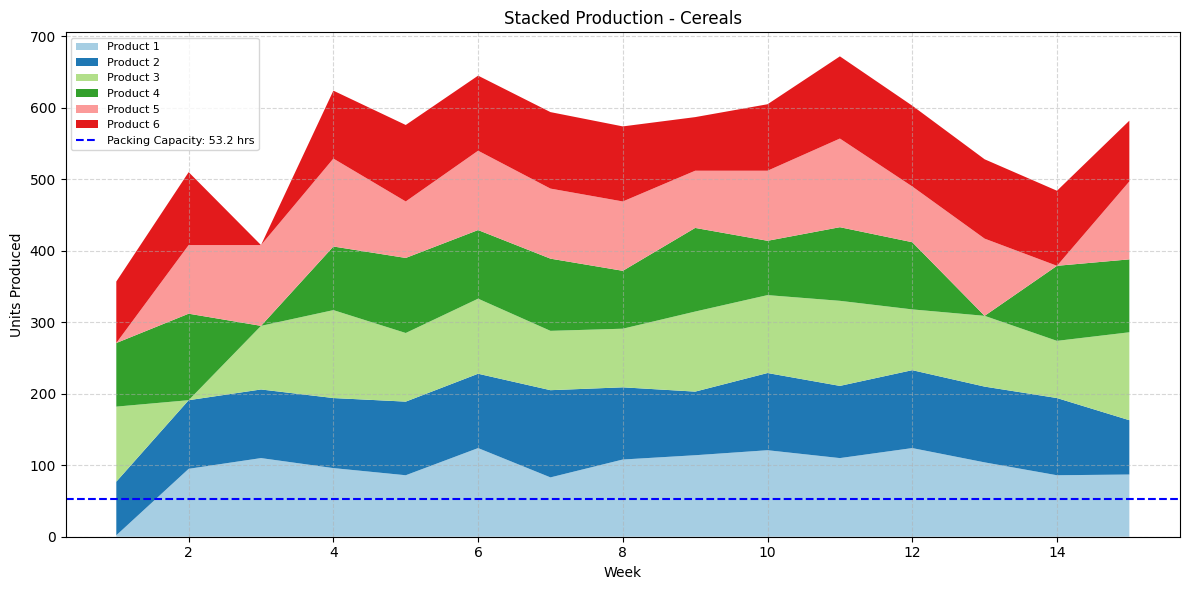

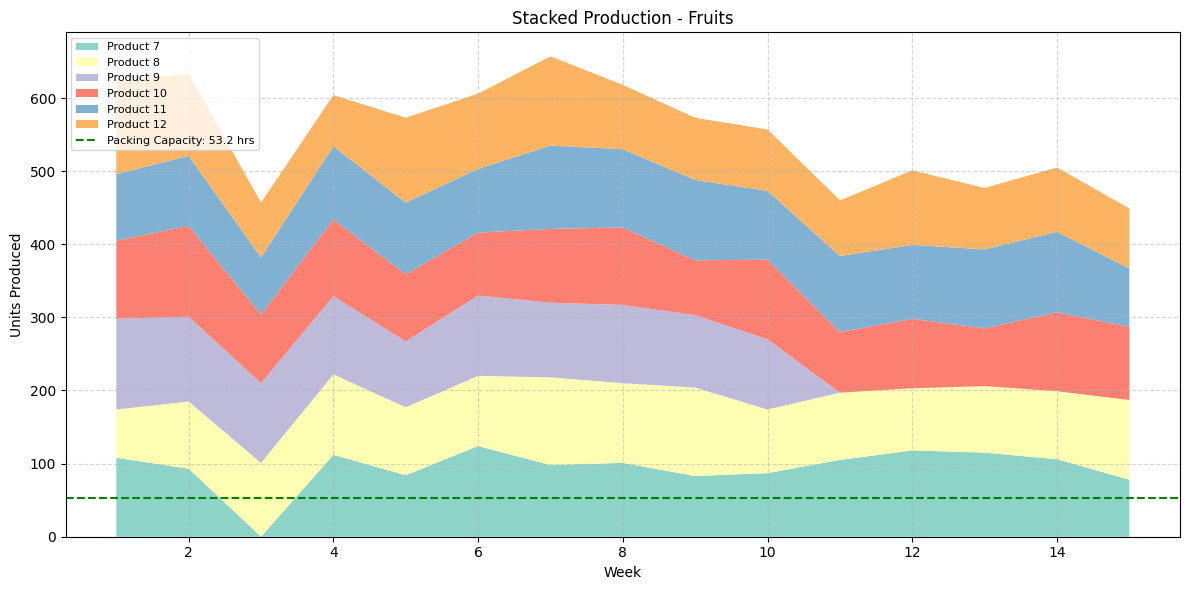

In [7]:


weeks = list(range(1, num_periods + 1))
cereal_production = np.array([production_results[p] for p in range(6)])     # Products 1–6
fruit_production = np.array([production_results[p] for p in range(6, 12)])  # Products 7–12

# Distinct color palettes for readability
cereal_colors = plt.cm.Paired(range(6))      # 6 unique colors for cereals
fruit_colors = plt.cm.Set3(range(6))         # 6 different colors for fruits

# Plot Cereals
plt.figure(figsize=(12, 6))
plt.stackplot(weeks, cereal_production, labels=[f'Product {p+1}' for p in range(6)], colors=cereal_colors)
plt.axhline(y=available_packing_cereals, color='blue', linestyle='--', label=f'Packing Capacity: {available_packing_cereals:.1f} hrs')
plt.title("Stacked Production - Cereals")
plt.xlabel("Week")
plt.ylabel("Units Produced")
plt.legend(loc='upper left', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Fruits
plt.figure(figsize=(12, 6))
plt.stackplot(weeks, fruit_production, labels=[f'Product {p+1}' for p in range(6, 12)], colors=fruit_colors)
plt.axhline(y=available_packing_fruits, color='green', linestyle='--', label=f'Packing Capacity: {available_packing_fruits:.1f} hrs')
plt.title("Stacked Production - Fruits")
plt.xlabel("Week")
plt.ylabel("Units Produced")
plt.legend(loc='upper left', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




In [8]:
# --------------------------
# Time Usage Summary Table (with TOTAL per period)
# --------------------------

# Ensure all columns show in the same row
pd.set_option('display.max_columns', None)

# Period labels (e.g., Week 1 to Week 15)
period_labels = [f"Week {i+1}" for i in range(num_periods)]

# Initialize time tracking lists
mixing_usage = []
setup_usage = []
packing_cereals = []
packing_fruits = []

# Loop through each week to calculate time usage
for t in range(num_periods):
    # Mixing usage (sum over all products)
    mixing = sum(production_results[p][t] * mixing_time_per_unit[p] for p in range(num_products))

    # Setup/cleaning time for each product that had setup
    cleaning = sum(setup_results[p][t] * cleaning_time[p] for p in range(num_products))

    # Packing time (Cereals = products 0 to 5, Fruits = products 6 to 11)
    pack_cereal = sum(production_results[p][t] * packing_time_per_unit[p] for p in range(6))
    pack_fruit = sum(production_results[p][t] * packing_time_per_unit[p] for p in range(6, 12))

    # Append to lists
    mixing_usage.append(mixing)
    setup_usage.append(cleaning)
    packing_cereals.append(pack_cereal)
    packing_fruits.append(pack_fruit)

# Total mixing time (mixing + setup)
total_mixing = [mixing_usage[i] + setup_usage[i] for i in range(num_periods)]

# Total usage per week (mixing + packing)
total_per_period = [
    total_mixing[i] + packing_cereals[i] + packing_fruits[i]
    for i in range(num_periods)
]

# Create DataFrame for time usage
df_time_usage = pd.DataFrame({
    "Mixing": mixing_usage,
    "Setup (Cleaning)": setup_usage,
    "Total Mixing": total_mixing,
    "Packing Cereals": packing_cereals,
    "Packing Fruits": packing_fruits,
    "Grand Total (All)": total_per_period
}, index=period_labels)

# Print the summary table
print("\n📋 Time Usage Summary by Period (with Grand Total):\n")
print(df_time_usage.round(1))

# --------------------------
# Summary Totals vs Capacity
# --------------------------

# Total used time per section
total_mixing_used = sum(total_mixing)
total_packing_used = [
    sum(packing_cereals),
    sum(packing_fruits)
]

# Total capacity over the entire horizon
total_mixing_capacity = available_mixing_hours * num_periods
total_packing_capacity = [
    available_packing_cereals * num_periods,
    available_packing_fruits * num_periods
]

# Create summary DataFrame
df_summary = pd.DataFrame({
    "Total Used (hrs)": [
        total_mixing_used,
        total_packing_used[0],
        total_packing_used[1]
    ],
    "Available Capacity (hrs)": [
        total_mixing_capacity,
        total_packing_capacity[0],
        total_packing_capacity[1]
    ]
}, index=["Mixing (shared)", "Packing Cereals", "Packing Fruits"])

# Add Utilization column (%)
df_summary["Utilization (%)"] = (
    df_summary["Total Used (hrs)"] / df_summary["Available Capacity (hrs)"] * 100
)

print("\n📊 Summary of Total Usage vs Capacity:\n")
print(df_summary.round(1))


# --------------------------
# Peak Weekly Usage vs Capacity
# --------------------------

# Peak usage in any week (max across periods)
peak_mixing = max(total_mixing)
peak_pack_cereal = max(packing_cereals)
peak_pack_fruit = max(packing_fruits)

# Create peak weekly utilization table
df_peak_utilization = pd.DataFrame({
    "Peak Usage (hrs)": [
        peak_mixing,
        peak_pack_cereal,
        peak_pack_fruit
    ],
    "Weekly Capacity (hrs)": [
        available_mixing_hours,
        available_packing_cereals,
        available_packing_fruits
    ]
}, index=["Mixing (shared)", "Packing Cereals", "Packing Fruits"])

# Calculate max weekly utilization %
df_peak_utilization["Max Utilization (%)"] = (
    df_peak_utilization["Peak Usage (hrs)"] / df_peak_utilization["Weekly Capacity (hrs)"] * 100
)

print("\n📈 Peak Weekly Usage vs Capacity:\n")
print(df_peak_utilization.round(1))




📋 Time Usage Summary by Period (with Grand Total):

         Mixing  Setup (Cleaning)  Total Mixing  Packing Cereals  \
Week 1     49.0               4.8          53.8             11.9   
Week 2     57.2               5.0          62.2             17.0   
Week 3     43.2               4.3          47.6             13.6   
Week 4     61.4               5.5          66.9             20.8   
Week 5     57.4               5.5          63.0             19.2   
Week 6     62.6               5.5          68.0             21.5   
Week 7     62.6               5.5          68.1             19.8   
Week 8     59.6               5.5          65.1             19.1   
Week 9     58.0               5.5          63.5             19.6   
Week 10    58.1               5.5          63.6             20.2   
Week 11    56.6               5.0          61.6             22.4   
Week 12    55.2               5.0          60.2             20.1   
Week 13    50.3               4.7          54.9             17.

<ipython-input-9-b9a6a705c18a>:28: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


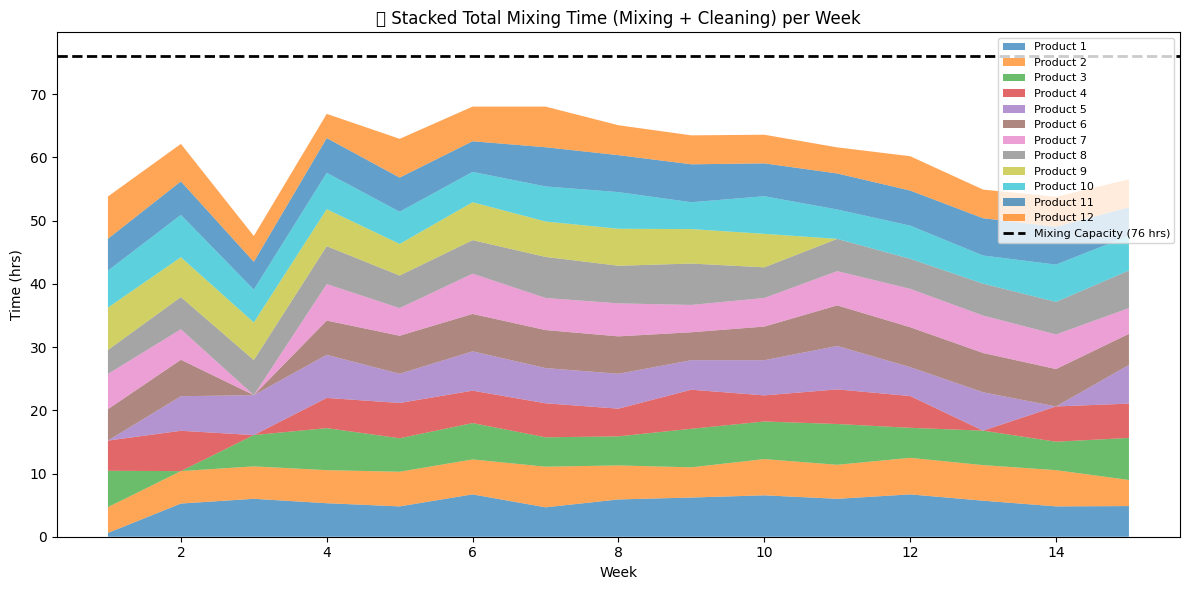

<ipython-input-9-b9a6a705c18a>:47: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


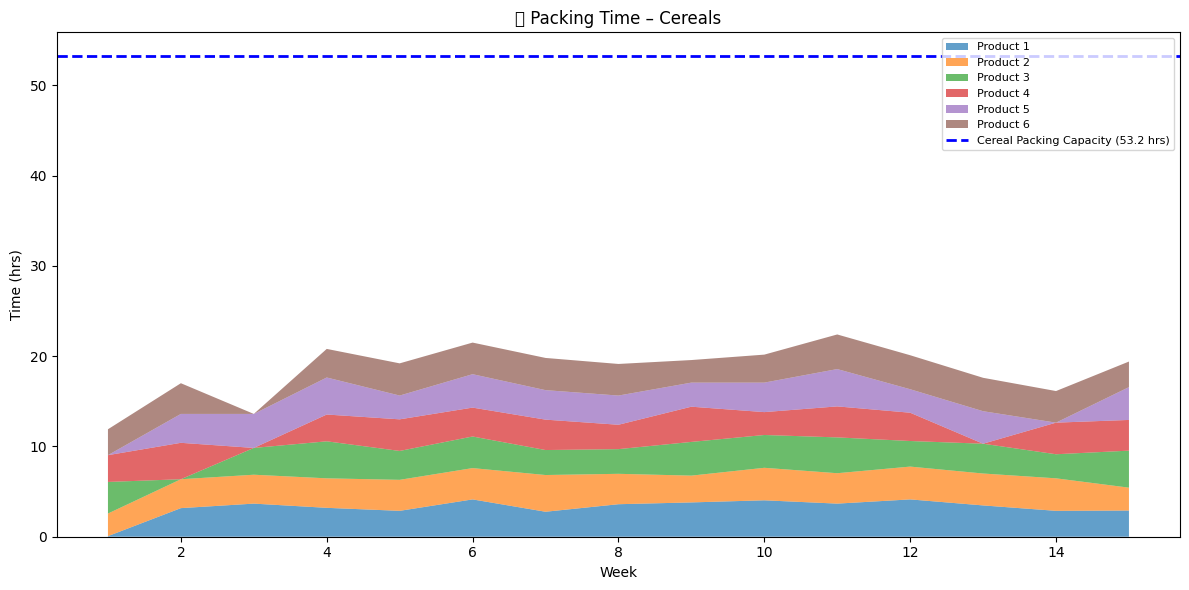

<ipython-input-9-b9a6a705c18a>:66: UserWarning: Glyph 127827 (\N{STRAWBERRY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127827 (\N{STRAWBERRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


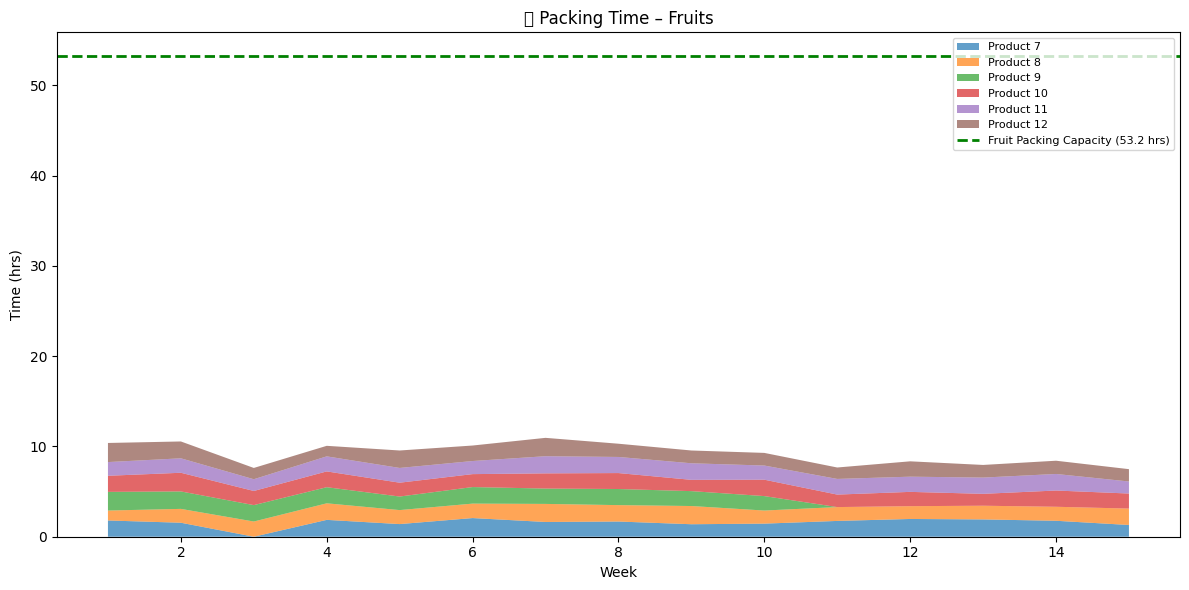

In [9]:

# ------------------------------------------
# Preparar variables necesarias
# ------------------------------------------
weeks = list(range(1, num_periods + 1))
products = list(range(num_products))

prod_df = pd.DataFrame(production_results, index=[f"Product {i+1}" for i in range(num_products)])
setup_df = pd.DataFrame(setup_results, index=[f"Product {i+1}" for i in range(num_products)])

# ------------------------------------------
# TOTAL TIME = Mixing + Cleaning Time
# ------------------------------------------
total_mixing_setup_times = [
    [
        production_results[p][t] * mixing_time_per_unit[p] + setup_results[p][t] * cleaning_time[p]
        for t in range(num_periods)
    ]
    for p in range(num_products)
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, total_mixing_setup_times, labels=[f"Product {i+1}" for i in products], alpha=0.7)
plt.axhline(available_mixing_hours, color='black', linestyle='--', linewidth=2, label='Mixing Capacity (76 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("🧪 Stacked Total Mixing Time (Mixing + Cleaning) per Week")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# ------------------------------------------
# Packing Time – Cereals (Products 1–6)
# ------------------------------------------
cereal_indices = list(range(6))
packing_cereal_times = [
    [production_results[p][t] * packing_time_per_unit[p] for t in range(num_periods)]
    for p in cereal_indices
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, packing_cereal_times, labels=[f"Product {i+1}" for i in cereal_indices], alpha=0.7)
plt.axhline(available_packing_cereals, color='blue', linestyle='--', linewidth=2, label='Cereal Packing Capacity (53.2 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("📦 Packing Time – Cereals")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# ------------------------------------------
# Packing Time – Fruits (Products 7–12)
# ------------------------------------------
fruit_indices = list(range(6, 12))
packing_fruit_times = [
    [production_results[p][t] * packing_time_per_unit[p] for t in range(num_periods)]
    for p in fruit_indices
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, packing_fruit_times, labels=[f"Product {i+1}" for i in fruit_indices], alpha=0.7)
plt.axhline(available_packing_fruits, color='green', linestyle='--', linewidth=2, label='Fruit Packing Capacity (53.2 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("🍓 Packing Time – Fruits")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


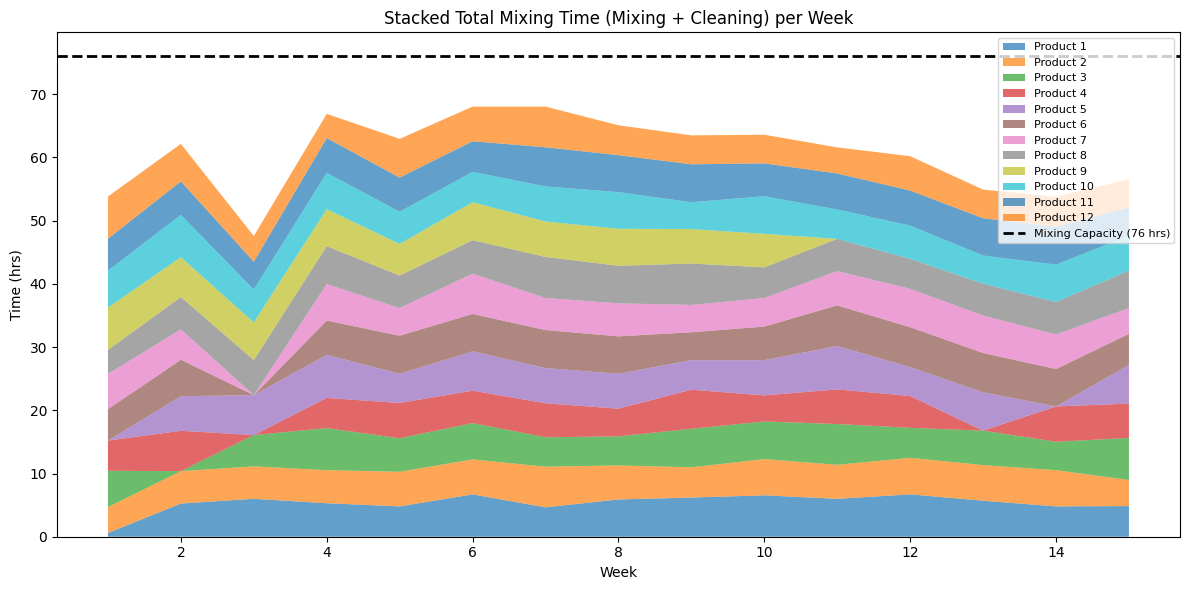

<ipython-input-10-075620d43eee>:46: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


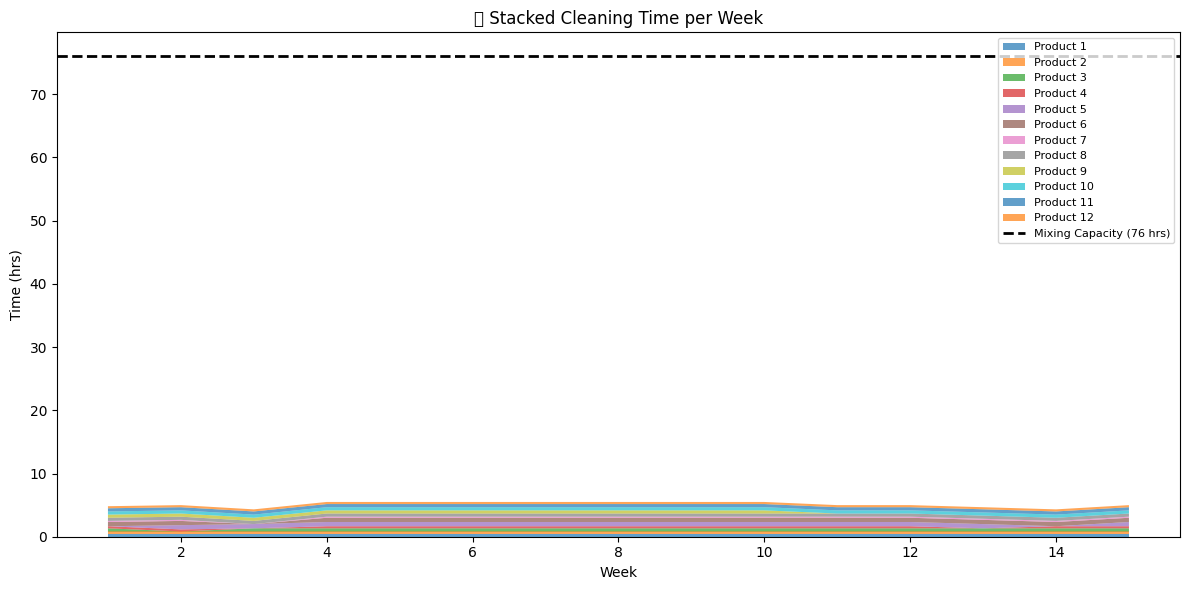

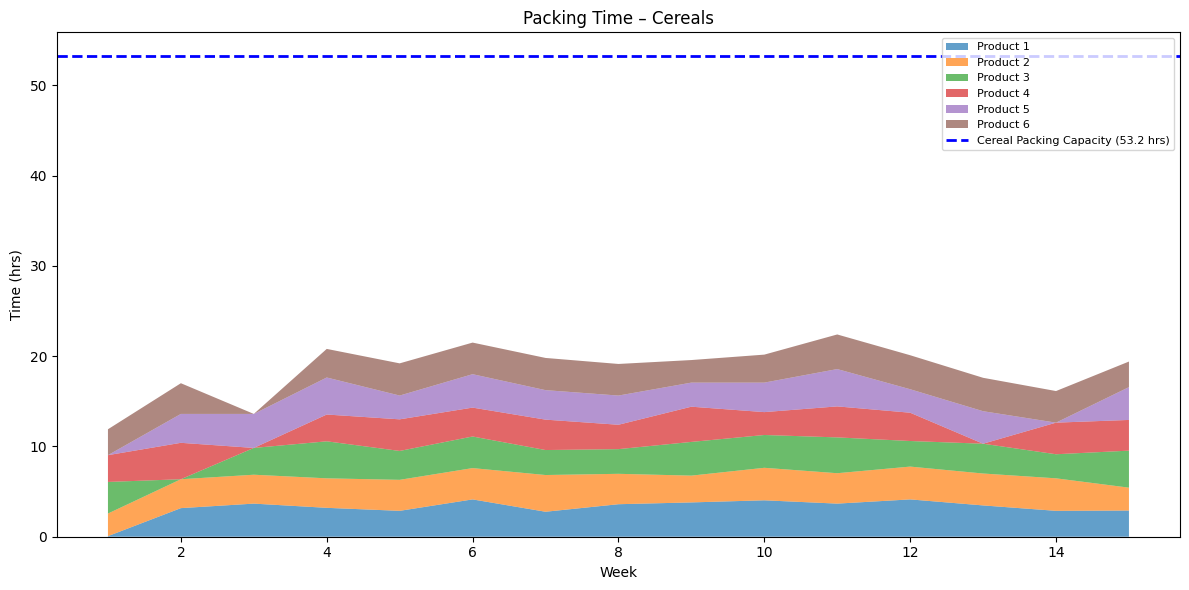

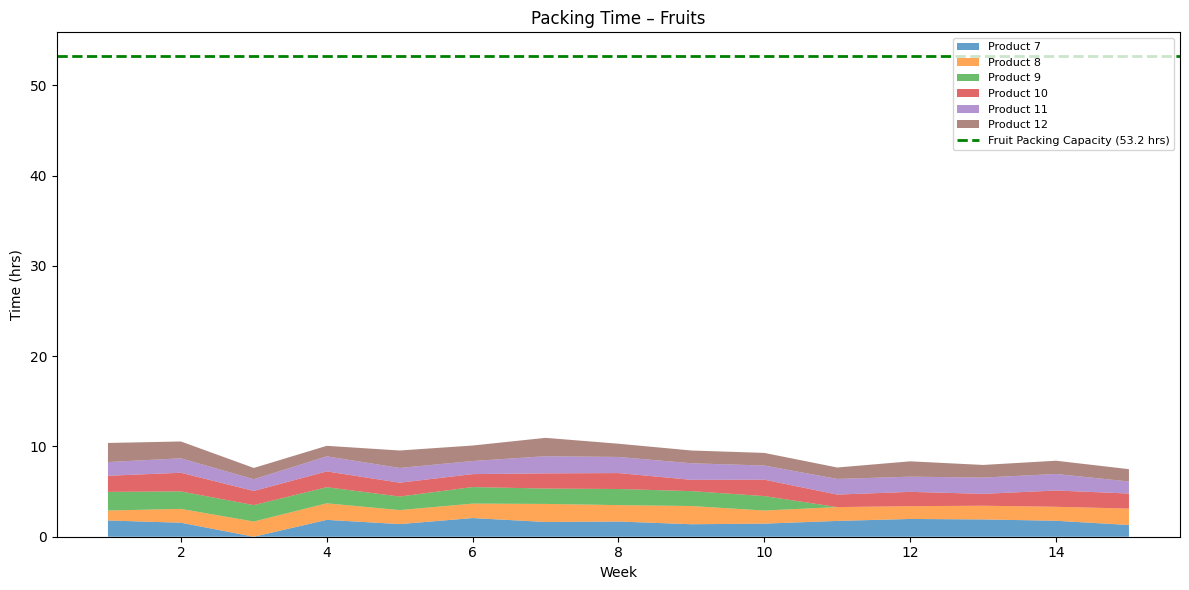

In [10]:

# ------------------------
# Variables
# ------------------------
weeks = list(range(1, num_periods + 1))
products = list(range(num_products))

prod_df = pd.DataFrame(production_results, index=[f"Product {i+1}" for i in products])
setup_df = pd.DataFrame(setup_results, index=[f"Product {i+1}" for i in products])

# ------------------------
# Combined Mixing + Setup Time per Product
# ------------------------
total_mixing_setup_times = [
    [
        production_results[p][t] * mixing_time_per_unit[p] + setup_results[p][t] * cleaning_time[p]
        for t in range(num_periods)
    ]
    for p in products
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, total_mixing_setup_times, labels=[f"Product {i+1}" for i in products], alpha=0.7)
plt.axhline(available_mixing_hours, color='black', linestyle='--', linewidth=2, label='Mixing Capacity (76 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("Stacked Total Mixing Time (Mixing + Cleaning) per Week")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# ------------------------
# Setup Time per Product
# ------------------------
setup_times = [
    [setup_results[p][t] * cleaning_time[p] for t in range(num_periods)]
    for p in products
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, setup_times, labels=[f"Product {i+1}" for i in products], alpha=0.7)
plt.axhline(available_mixing_hours, color='black', linestyle='--', linewidth=2, label='Mixing Capacity (76 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("🧼 Stacked Cleaning Time per Week")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# ------------------------
# Packing Time – Cereals (Products 1–6)
# ------------------------
cereal_indices = list(range(6))
packing_cereal_times = [
    [production_results[p][t] * packing_time_per_unit[p] for t in range(num_periods)]
    for p in cereal_indices
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, packing_cereal_times, labels=[f"Product {i+1}" for i in cereal_indices], alpha=0.7)
plt.axhline(available_packing_cereals, color='blue', linestyle='--', linewidth=2, label='Cereal Packing Capacity (53.2 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("Packing Time – Cereals")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# ------------------------
# Packing Time – Fruits (Products 7–12)
# ------------------------
fruit_indices = list(range(6, 12))
packing_fruit_times = [
    [production_results[p][t] * packing_time_per_unit[p] for t in range(num_periods)]
    for p in fruit_indices
]

plt.figure(figsize=(12, 6))
plt.stackplot(weeks, packing_fruit_times, labels=[f"Product {i+1}" for i in fruit_indices], alpha=0.7)
plt.axhline(available_packing_fruits, color='green', linestyle='--', linewidth=2, label='Fruit Packing Capacity (53.2 hrs)')
plt.xlabel("Week")
plt.ylabel("Time (hrs)")
plt.title("Packing Time – Fruits")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()



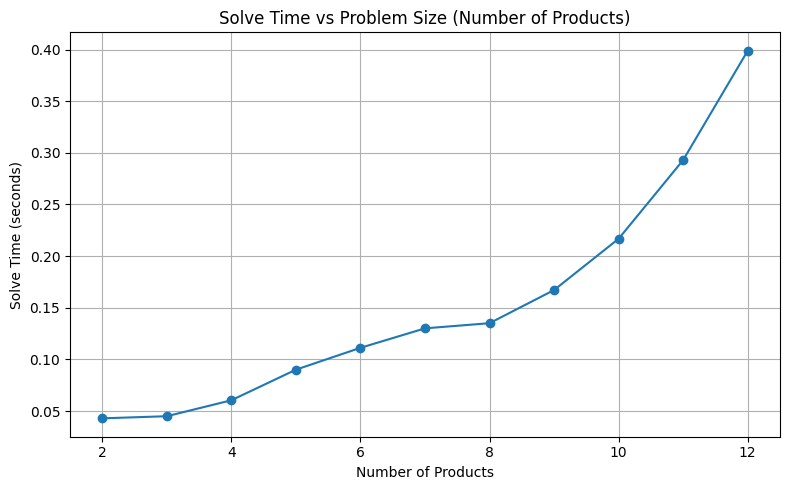

In [14]:


# Store solve times by number of products
solve_times = []
product_range = list(range(2, 13))  # From 2 to 12 products

# Fix number of periods
num_periods = 15

# Extract base data for all 12 products
all_demand = [
    [0, 95, 110, 96, 86, 124, 83, 108, 114, 121, 110, 124, 104, 86, 87],
    [98, 96, 96, 98, 103, 104, 122, 101, 89, 108, 101, 109, 106, 108, 76],
    [106, 0, 89, 123, 96, 105, 83, 82, 112, 109, 119, 85, 99, 80, 123],
    [98, 121, 0, 89, 105, 96, 101, 81, 117, 76, 103, 89, 5, 105, 102],
    [0, 124, 113, 123, 79, 111, 98, 97, 80, 98, 124, 78, 108, 0, 109],
    [103, 102, 0, 95, 107, 105, 107, 105, 75, 93, 115, 113, 111, 105, 85],
    [110, 93, 0, 112, 84, 124, 98, 101, 83, 87, 105, 118, 115, 106, 78],
    [85, 92, 101, 110, 93, 96, 120, 109, 121, 87, 92, 85, 91, 93, 109],
    [122, 116, 109, 107, 90, 110, 102, 107, 99, 96, 0, 0, 0, 0, 0],
    [120, 124, 94, 105, 92, 86, 101, 106, 75, 109, 83, 95, 79, 108, 100],
    [117, 96, 78, 100, 98, 87, 114, 107, 110, 94, 104, 101, 108, 110, 80],
    [125, 112, 75, 70, 116, 103, 122, 88, 85, 84, 76, 102, 84, 88, 82]
]

all_initial_inventory = [8, 33, 11, 19, 38, 27, 22, 39, 18, 33, 46, 18]
all_safety_stock = [10]*6 + [20]*6
mixing_time_per_unit = [0.05] * 12
cleaning_time = [0.5, 0.33, 0.5, 0.33, 0.67, 0.67, 0.17, 0.5, 0.5, 0.5, 0.5, 0.33]
packing_time_per_unit = [2/60]*6 + [1/60]*6

# Capacity
available_mixing_hours = 76
available_packing_cereals = 53.2
available_packing_fruits = 53.2

for n_products in product_range:
    model = pulp.LpProblem("Production_Planning", pulp.LpMinimize)

    # Slice data
    demand = all_demand[:n_products]
    initial_inventory = all_initial_inventory[:n_products]
    safety_stock = [ [all_safety_stock[p]] * num_periods for p in range(n_products) ]
    mix_time = mixing_time_per_unit[:n_products]
    clean_time = cleaning_time[:n_products]
    pack_time = packing_time_per_unit[:n_products]

    production = pulp.LpVariable.dicts("production", (range(n_products), range(num_periods)), lowBound=0, cat="Continuous")
    inventory = pulp.LpVariable.dicts("inventory", (range(n_products), range(num_periods)), lowBound=0, cat="Continuous")
    setup = pulp.LpVariable.dicts("setup", (range(n_products), range(num_periods)), cat="Binary")

    model += pulp.lpSum(
        production[p][t] * 50 + inventory[p][t] * 5 + setup[p][t] * 100
        for p in range(n_products) for t in range(num_periods)
    )

    for p in range(n_products):
        for t in range(num_periods):
            if t == 0:
                model += inventory[p][t] == initial_inventory[p] + production[p][t] - demand[p][t]
            else:
                model += inventory[p][t] == inventory[p][t-1] + production[p][t] - demand[p][t]

            model += inventory[p][t] >= safety_stock[p][t]
            future_dem = pulp.lpSum(demand[p][k] + safety_stock[p][k] for k in range(t, num_periods))
            model += production[p][t] <= future_dem * setup[p][t]

    for t in range(num_periods):
        model += pulp.lpSum(
            production[p][t] * mix_time[p] + setup[p][t] * clean_time[p]
            for p in range(n_products)
        ) <= available_mixing_hours

    for p in range(n_products):
        for t in range(num_periods):
            if p <= 5:
                model += production[p][t] * pack_time[p] <= available_packing_cereals
            else:
                model += production[p][t] * pack_time[p] <= available_packing_fruits

    start = time.time()
    model.solve()
    end = time.time()

    solve_times.append(end - start)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(product_range, solve_times, marker='o', linestyle='-')
plt.xlabel("Number of Products")
plt.ylabel("Solve Time (seconds)")
plt.title("Solve Time vs Problem Size (Number of Products)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:


# Sensitivity setup costs to test
setup_cost_values = [20, 50, 100, 200, 400]
total_costs = []
total_setups = []

for setup_c in setup_cost_values:
    model = pulp.LpProblem("Sensitivity_SetupCost", pulp.LpMinimize)

    # Variables
    production = pulp.LpVariable.dicts("production", (range(num_products), range(num_periods)), lowBound=0, cat="Continuous")
    inventory = pulp.LpVariable.dicts("inventory", (range(num_products), range(num_periods)), lowBound=0, cat="Continuous")
    setup = pulp.LpVariable.dicts("setup", (range(num_products), range(num_periods)), cat="Binary")

    # Objective function
    model += pulp.lpSum(
        production[p][t] * production_cost[p] +
        inventory[p][t] * inventory_cost[p] +
        setup[p][t] * setup_c
        for p in range(num_products) for t in range(num_periods)
    )

    # Inventory balance and safety stock
    for p in range(num_products):
        for t in range(num_periods):
            if t == 0:
                model += inventory[p][t] == initial_inventory[p] + production[p][t] - demand[p][t]
            else:
                model += inventory[p][t] == inventory[p][t-1] + production[p][t] - demand[p][t]

            model += inventory[p][t] >= safety_stock[p][t]

            # If no setup, no production
            future_dem = pulp.lpSum(demand[p][k] + safety_stock[p][k] for k in range(t, num_periods))
            model += production[p][t] <= future_dem * setup[p][t]

    # Shared mixing capacity
    for t in range(num_periods):
        model += pulp.lpSum(
            production[p][t] * mixing_time_per_unit[p] + setup[p][t] * cleaning_time[p]
            for p in range(num_products)
        ) <= available_mixing_hours

    # Packing capacity per group
    for p in range(num_products):
        for t in range(num_periods):
            if p <= 5:  # Cereals
                model += production[p][t] * packing_time_per_unit[p] <= available_packing_cereals
            else:       # Fruits
                model += production[p][t] * packing_time_per_unit[p] <= available_packing_fruits

    # Solve and collect results
    model.solve()
    total_costs.append(pulp.value(model.objective))
    total_setups.append(sum(setup[p][t].varValue for p in range(num_products) for t in range(num_periods)))


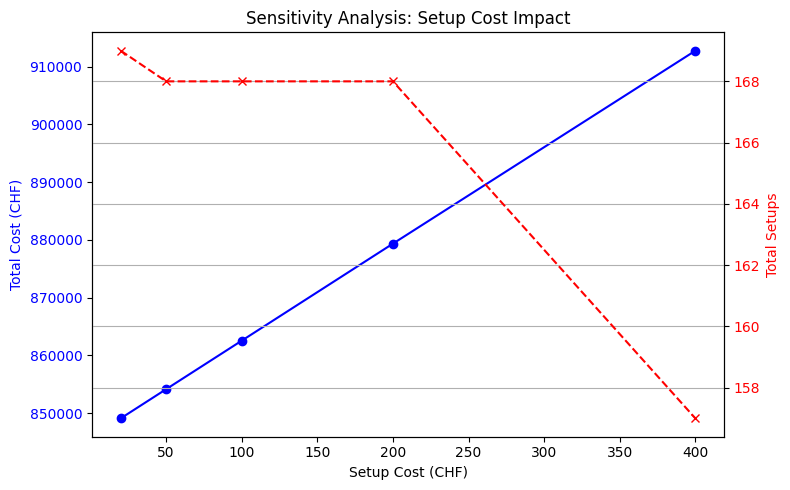

In [16]:
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel('Setup Cost (CHF)')
ax1.set_ylabel('Total Cost (CHF)', color='blue')
ax1.plot(setup_cost_values, total_costs, color='blue', marker='o', label='Total Cost')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Total Setups', color='red')
ax2.plot(setup_cost_values, total_setups, color='red', marker='x', linestyle='--', label='Total Setups')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Sensitivity Analysis: Setup Cost Impact")
fig.tight_layout()
plt.grid(True)
plt.show()
